<hr>
<h1>Examples</h1>
<hr>

### Please see the [scikit-image documentation](https://scikit-image.org/docs/stable/index.html), especially:
- [User Guide](https://scikit-image.org/docs/stable/user_guide.html)
- [Examples](https://scikit-image.org/docs/stable/auto_examples/)

In [52]:
import numpy as np

In [53]:
from pathlib import Path

In [54]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [58]:
from skimage.io import imread, imsave

In [125]:
from skimage.color import rgb2gray, label2rgb
from skimage import img_as_float
#img_as_float(leaf)

In [343]:
data_dir = Path('..') / 'data'
blobs = imread(str(data_dir/'ij-samples'/'blobs.gif'))
leaf = imread(str(data_dir/'ij-samples'/'leaf.jpg'))
flybrain = imread(str(data_dir/'ij-samples'/'flybrain.tif'))

In [344]:
blobs = img_as_float(blobs)

np.random.seed(42)
files = (data_dir / 'dsb2018' / 'train' / 'images').glob('*.tif')
files = sorted(files)
np.random.shuffle(files)
foo = imread(files[0])

In [391]:
f = '4c032609d377bd980e01f888e0b298600bf8af0e33c4271a1f3aaf76964dce06.tif'
image = imread(str(data_dir.joinpath('dsb2018','train','images',f)))
mask  = imread(str(data_dir.joinpath('dsb2018','train','masks',f)))

Outlier-robust normalization, constrast, brightness

In [392]:
from csbdeep.utils import normalize
x = normalize(image, 3, 99.8, clip=True)

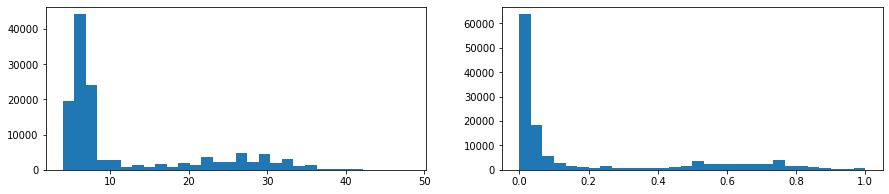

In [393]:
plt.figure(figsize=(15,3))
plt.subplot(1,2,1); plt.hist(image.ravel(), bins=30)
plt.subplot(1,2,2); plt.hist(x.ravel(),     bins=30)
None;

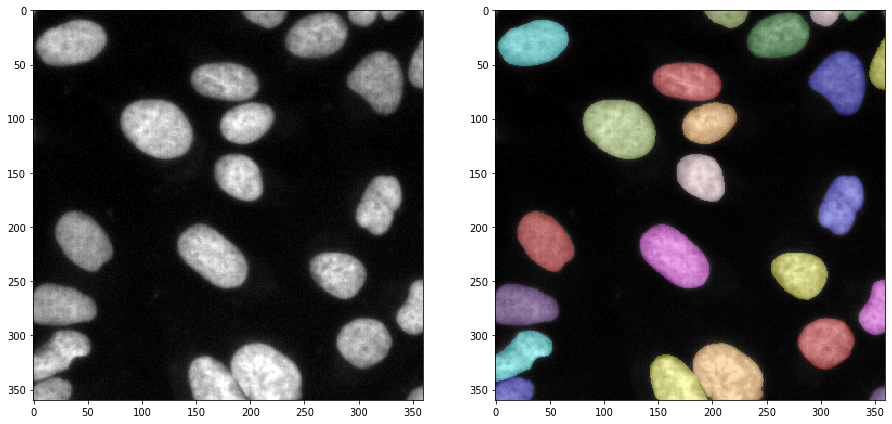

In [394]:
plt.figure(figsize=(13,6))
plt.subplot(1,2,1); plt.imshow(x, clim=(0,1), cmap='gray')
plt.subplot(1,2,2); plt.imshow(label2rgb(mask, image=x, bg_label=0))
plt.tight_layout()
None;

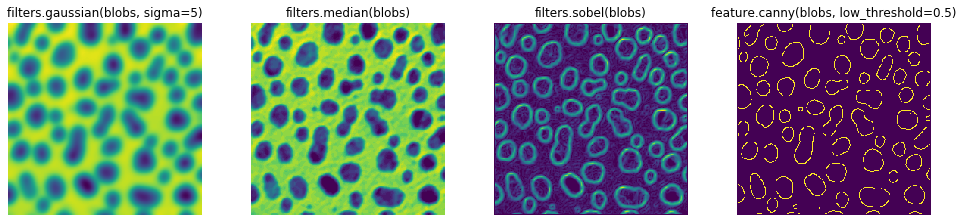

In [395]:
from skimage import filters, feature

example_filters = (
    ('filters.gaussian', dict(sigma=5)),
    ('filters.median', dict()),
    ('filters.sobel', dict()),
    ('feature.canny', dict(low_threshold=0.5)),
)

fig, ax = plt.subplots(1,len(example_filters), figsize=(14,10))

for a, (filt, filt_kwargs) in zip(ax.ravel(), example_filters):
    a.imshow(eval(filt)(blobs, **filt_kwargs))
    t = ", ".join([f"{k}={v}" for k,v in filt_kwargs.items()])
    a.set_title(f"{filt}(blobs{', '+t if len(t)>0 else ''})")

plt.tight_layout()
[a.axis('off') for a in ax.ravel()]
None;

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


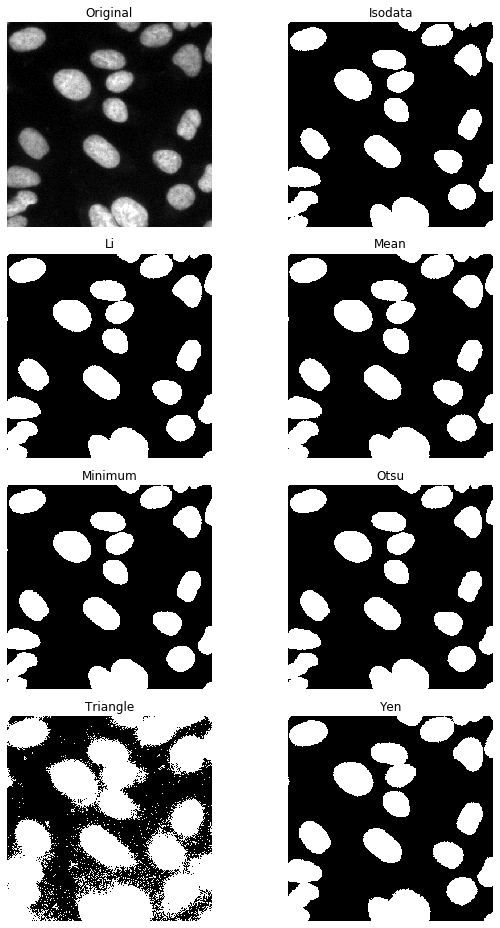

In [396]:
filters.try_all_threshold(x, figsize=(9,13));

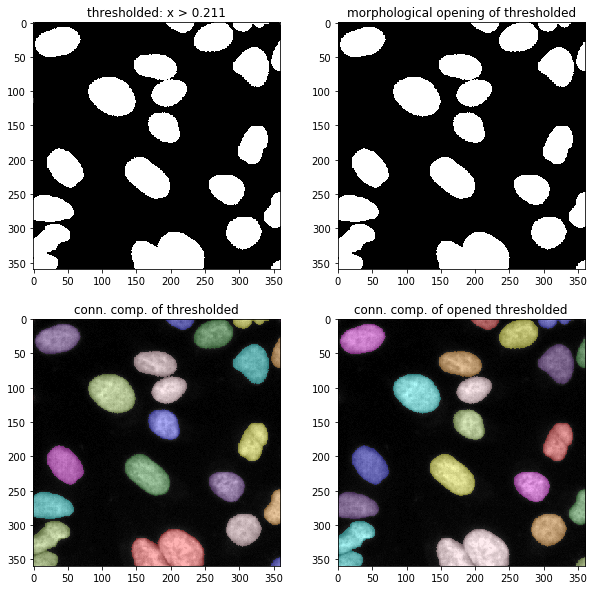

In [558]:
from skimage.morphology import opening, disk
from scipy.ndimage import label

thresh = filters.threshold_li(x)
x_thresholded = x > thresh
labels = label(x_thresholded)[0]

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(x_thresholded, cmap='gray')
plt.title(f"thresholded: x > {thresh:.3}")
plt.subplot(2,2,3)
plt.imshow(label2rgb(labels, image=x, bg_label=0))
plt.title(f"conn. comp. of thresholded")

x_thr_opened = opening(x_thresholded, selem=disk(5))
labels = label(x_thr_opened)[0]

plt.subplot(2,2,2)
plt.imshow(x_thr_opened, cmap='gray')
plt.title("morphological opening of thresholded")
plt.subplot(2,2,4)
plt.imshow(label2rgb(labels, image=x, bg_label=0))
plt.title(f"conn. comp. of opened thresholded")
None;

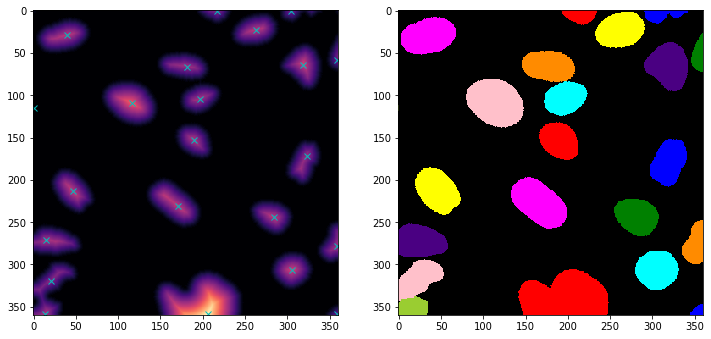

In [674]:
from skimage.measure import regionprops
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy.ndimage import distance_transform_edt

dist = distance_transform_edt(x_thresholded)
dist += np.random.uniform(0,1e-3,size=dist.shape) # bad hack: tiebreaker for identical dist values

peaks = peak_local_max(dist, min_distance=25, indices=False, labels=x_thresholded, exclude_border=False)
markers = label(peaks)[0]
labels = watershed(-dist, markers=markers, mask=x_thresholded)

plt.figure(figsize=(12,7))
plt.subplot(1,2,1)
plt.imshow(dist, cmap='magma')
rr,cc = np.nonzero(peaks)
plt.plot(cc,rr,'xc')
plt.subplot(1,2,2)
plt.imshow(label2rgb(labels, image=None, bg_label=0))
None;

In [691]:
regions = regionprops(labels)

In [693]:
[print(a) for a in dir(regions[0]) if not a.startswith('_')];

area
bbox
bbox_area
centroid
convex_area
convex_image
coords
eccentricity
equivalent_diameter
euler_number
extent
filled_area
filled_image
image
inertia_tensor
inertia_tensor_eigvals
intensity_image
label
local_centroid
major_axis_length
max_intensity
mean_intensity
min_intensity
minor_axis_length
moments
moments_central
moments_hu
moments_normalized
orientation
perimeter
slice
solidity
weighted_centroid
weighted_local_centroid
weighted_moments
weighted_moments_central
weighted_moments_hu
weighted_moments_normalized


Areas: [7, 141, 447, 519, 527, 682, 930, 1551, 1582, 1649, 1749, 1771, 1861, 1871, 1894, 1931, 2090, 2126, 2204, 2655, 2964, 4486]


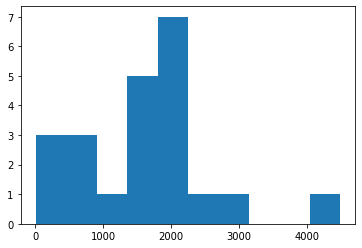

In [700]:
plt.hist([r.area for r in regions])
print("Areas:", sorted([r.area for r in regions]));

soft skills more important than showing actual algorithms, since people should know them from fiji anyway

explain notebooks vs. scripts vs. packages

- prototype in notebooks or ipython interactove shell
- deploy established workflows as scripts (with argparse)
- create packages for your own recurring functions (deploy via pip/conda)

have little script example that uses argparse to process images in a folder

algorithms

- low-level
    - rescaling, resizing, rotate
    - brightness, contrast adjustments
    - filtering: median, gauss, min/max, etc.
    - edge detection
- segmentation
    - thresholding
    - connected components
    - watershed
- measurements & display
    - regionsprops
    - plotting labelings, label2rgb
- restoration
    - denoising: bilateral, nlm, bm3d
    - deconvolution: LR
    - image quality: psnr, ssim
- shape / misc
    - morphological operations
    - skeletonize
    - hough?
    - blob detection
    - peak finding

SciPy?

GUIs
- napari
- spimagine

In [ ]:
np.lookfor('contour', 'skimage')

# Rant

Use Python 3

Python 2 support discontinued 2020?

For example, pathlib not in Python 2

In [ ]:
%load_ext autoreload
%autoreload 2

a,b=np.unique(x, return_counts=True)

plt.plot(a,b,'.-')

plt.hist(x.ravel(), bins=100);